# Concrete Strength Prediction Using Neural Networks in Keras 

## Import Main Libraries 

In [1]:
# main library imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.stats import zscore 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from math import sqrt
from statistics import mean, stdev
from IPython.display import clear_output
import time

In [2]:
# dowload keras and tensorflow and import
# download and import keras to build the neural network 
#!pip install tensorFlow
#!pip install keras
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 

In [3]:
concrete_data = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0101EN/labs/data/concrete_data.csv')
concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


- Units: kg/m^3 for volumetric elements, MPa for Strength, days for age

- Coming from a structural engineering background, I want to add another feature to this 
dataset. The feauture is the ratio of water to cement and it is often used by engineers to estimate concrete strength. I'll call this feature 'WC Ratio'

In [4]:
# add the new feature to the dataframe 
concrete_data['WC Ratio'] = round(concrete_data['Water']/concrete_data['Cement'],3)
concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,WC Ratio
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.300
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0.300
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0.686
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0.686
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0.967


## Explore the Dataset 

In [5]:
# check how many rows we have 
og_num_rows = concrete_data.shape[0]
og_num_cols = concrete_data.shape[1]
print(f'The dataframe has {og_num_rows} Rows and {og_num_cols} Columns')

The dataframe has 1030 Rows and 10 Columns


In [6]:
# check if there is any missing data
concrete_data.isnull().any()

Cement                False
Blast Furnace Slag    False
Fly Ash               False
Water                 False
Superplasticizer      False
Coarse Aggregate      False
Fine Aggregate        False
Age                   False
Strength              False
WC Ratio              False
dtype: bool

- There is no data missing from any of the columns which is good 

In [7]:
# check out the descriptive statistics of the dataset 
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,WC Ratio
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961,0.748284
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742,0.314000
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000,0.267000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000,0.533000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000,0.675500
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000,0.935000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000,1.882000


Text(0, 0.5, 'Average')

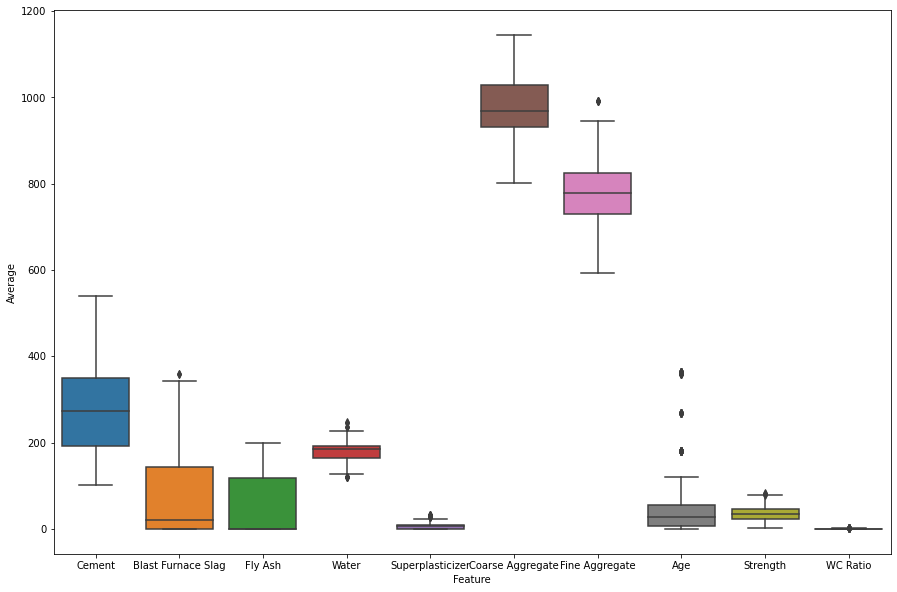

In [8]:
#create boxplot to visualize outliers
plt.figure(figsize = (15,10))
box = sns.boxplot(data=concrete_data)
plt.xlabel('Feature')
plt.ylabel('Average')

- The water, superplasricizer, fine aggregate, wc ratio, and age variables all contain some outliers so I decided to remove those outliers defined as the values that are 3 standard deviations (or more) away from the mean.

In [9]:
#remove outliers defined as values greater than 3 STD from the mean
z_scores = zscore(concrete_data) #z-score = (value-mean)/STD
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
concrete_data = concrete_data[filtered_entries]
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,WC Ratio
count,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.00000
mean,279.192791,72.222142,57.070855,180.504531,6.246138,975.459320,775.267044,36.502575,35.466849,0.74243
std,101.721352,85.185068,64.483566,20.014525,5.485649,77.774221,76.980734,36.921353,16.688221,0.29621
min,116.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,3.320000,0.28000
25%,192.000000,0.000000,0.000000,164.900000,0.000000,932.000000,739.000000,7.000000,23.455000,0.53350
50%,272.600000,20.000000,0.000000,183.800000,6.700000,970.000000,780.000000,28.000000,33.720000,0.67400
75%,349.500000,142.500000,118.300000,192.000000,10.300000,1040.000000,821.700000,28.000000,45.535000,0.93500
max,540.000000,316.100000,200.100000,228.000000,23.400000,1145.000000,992.600000,180.000000,82.600000,1.66000


- Removing outliers got rid of 59 samples. However, most of the descriptive statistics for strength remain the same. Also, some rows with very high age were removed. This is okay because an older concrete will not be as representative of its original design strength.

Text(0.5, 1.0, 'Feature Correlation')

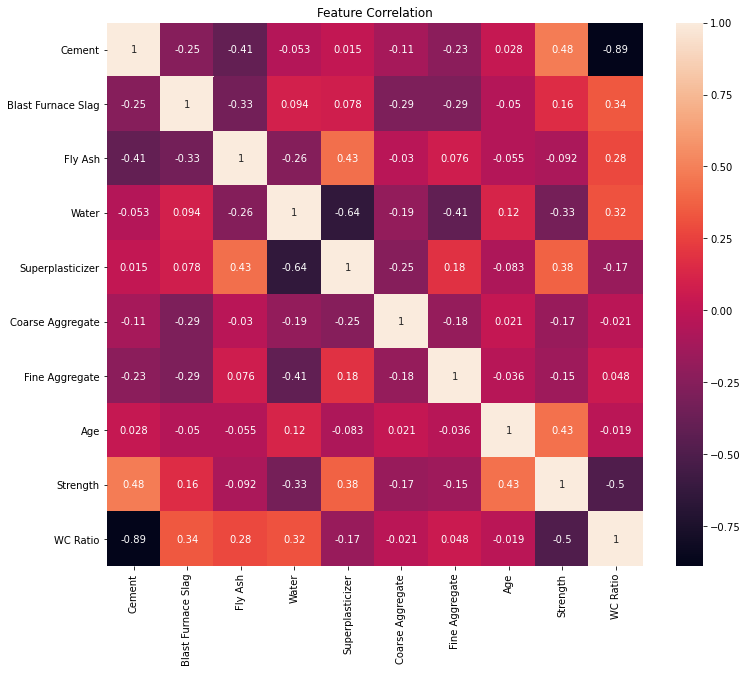

In [10]:
# check the correlation of the features 
plt.figure(figsize = (12, 10))
corr = concrete_data.corr()
sns.heatmap(corr,annot=True).set_title(f'Feature Correlation')

In [11]:
#display the correlation of each variable with strength 
corr.Strength

Cement                0.477993
Blast Furnace Slag    0.161386
Fly Ash              -0.091692
Water                -0.325331
Superplasticizer      0.377291
Coarse Aggregate     -0.168868
Fine Aggregate       -0.149891
Age                   0.432579
Strength              1.000000
WC Ratio             -0.496041
Name: Strength, dtype: float64

- No variables are that strongly correlated with strength so let's try to build a model with all of them.

- Since WC Ratio was added, it could also be useful to remove the water and cement variables to improve model efficiency. But we can test this out later

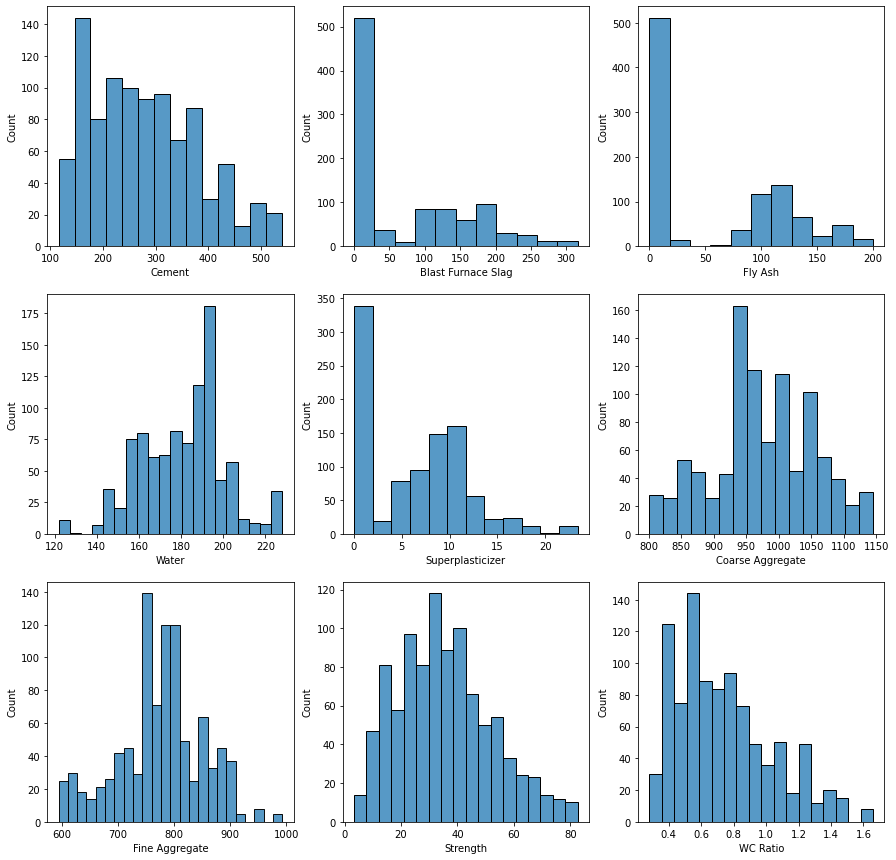

In [12]:
# visualize the distribution of the features 
plt.figure(figsize = (15, 15))
for idx,col in enumerate(concrete_data.columns,start=1):
    if idx==8:
        continue
    elif idx>8:
        idx=idx-1
    plt.subplot(3,3,idx)
    sns.histplot(data=concrete_data, x=col)

- Note for the variables of slag, fly ash, and superplasticizer, we have a lot of mixes with values of 0. In general, these components are the most expensive in concrete mixes and can be thought of as "add-ons", so it is reasonable that most mixes will not contain a lot of these components. I notice also that for fly ash there is not much data between 25-75 kg/m^3 and so I expect predictions for mixes wtih fly ash content in this range will not be very good.

## A. Build a Baseline Regression Model with Keras 

Use the Keras library to build a neural network with the following:

- One hidden layer with 10 nodes, and a ReLU activation function
- Use the ADAM optimizer and the mean squared error as the loss function.

In [13]:
# split the data into target and predictors 
concrete_data_columns = concrete_data.columns
# all columns except Strength
predictors = concrete_data[concrete_data_columns[concrete_data_columns != 'Strength']] 
target = concrete_data['Strength'] # Strength column

In [14]:
# check that the predictors are the ones we want 
predictors.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,WC Ratio
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,0.300
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,0.300
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,0.857
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,0.600
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,0.857


In [15]:
# check that the target is the strength column
target.head()

0    79.99
1    61.89
5    47.03
7    36.45
8    45.85
Name: Strength, dtype: float64

- Both predictor and strength variables look good!

For this baseline model, the data will not be normalized to check how the predictions are looking. For the last 2 models tested, the data will be normalized

In [16]:
# define the number of predictors
n_cols = predictors.shape[1] 
print(f'Number of columns = {n_cols}')

Number of columns = 9


In [17]:
# let's define a function to create the regression neural network using keras 
def regression_model():
    # create model
    model = Sequential()
    #add one hidden layer with 10 nodes and ReLu activation function
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Let's define a function below to perform iterations of the model using a defined number of epochs and return the mean and standard deviation of the root mean squared error 

In [18]:
def iterate_model(predictors,target,iterations,epochs):
    clear_output(wait=True)
    RMSE_by_iter = []
    
    for i in range(1,iterations+1):
        # split the data into train set (70%) and test set (30%)
        X_train, X_test, y_train, y_test = train_test_split(predictors, target, \
                                                         test_size=0.3, random_state=42)

        # build the model
        model = regression_model()
        # fit the model and hold out 30% of the data for testing 
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), \
                             epochs=epochs, verbose=0)

        # get predictions for strength 
        y_pred = model.predict(X_test)
        #get the root mean squared error 
        RMSE = round(sqrt(MSE(y_test, y_pred)),3)
        RMSE_by_iter.append(RMSE)
        if i == 1 or i%5 == 0:
            print(f'Iteration {i}: RMSE = {RMSE} MPa')
            
    mean_RMSE = round(mean(RMSE_by_iter),3)
    std_RMSE = round(stdev(RMSE_by_iter),3)
        
    return mean_RMSE, std_RMSE

- I chose to use root mean square error here since it is a little easier to quantify 

In [19]:
# define the iterations and epochs and then train the network
iterations = 50
epochs = 50 
# train the model and time how long it takes 
start = time.time()
mean_RMSE, std_RMSE = iterate_model(predictors,target,iterations,epochs)
end = time.time()
print(f'\nAfter {iterations} iterations using {epochs} epochs, the mean_RMSE = {mean_RMSE} MPa and std_RMSE = {std_RMSE} MPa')
timer = round((end-start)/60,3)
print(f'The model took {timer} minutes to train')

Iteration 1: RMSE = 10.617 MPa
Iteration 5: RMSE = 23.034 MPa
Iteration 10: RMSE = 9.95 MPa
Iteration 15: RMSE = 9.754 MPa
Iteration 20: RMSE = 14.334 MPa
Iteration 25: RMSE = 12.506 MPa
Iteration 30: RMSE = 10.337 MPa
Iteration 35: RMSE = 39.712 MPa
Iteration 40: RMSE = 11.106 MPa
Iteration 45: RMSE = 9.765 MPa
Iteration 50: RMSE = 24.224 MPa

After 50 iterations using 50 epochs, the mean_RMSE = 16.982 MPa and std_RMSE = 8.741 MPa
The model took 3.752 minutes to train


- The mean of the RMSE is around 17 MPa which is quite high and the standard deviation is 8.7 MPa. Let's see if normalizing the data, using more epochs, and more hidden layers will improve predictions.

## B. Normalize the Data and Re-Train the Same Neural Network

In [20]:
#normalize the predictor variables by subtracting the mean and dividing by standard deviation 
predictors_norm = (predictors - predictors.mean()) / predictors.std()
predictors_norm.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,WC Ratio
0,2.563938,-0.847826,-0.885045,-0.924555,-0.682898,0.829847,-1.289505,-0.230289,-1.493636
1,2.563938,-0.847826,-0.885045,-0.924555,-0.682898,1.022713,-1.289505,-0.230289,-1.493636
5,-0.129695,0.490436,-0.885045,2.373050,-1.138632,-0.558788,-1.367447,1.448956,0.386784
7,0.991013,0.267393,-0.885045,2.373050,-1.138632,-0.558788,-2.354707,-0.230289,-0.480842
8,-0.129695,0.490436,-0.885045,2.373050,-1.138632,-0.558788,-1.367447,-0.230289,0.386784


In [21]:
#define the iterations and epochs and then train the network on the normalized predictors 
iterations = 50
epochs = 50 
# train the model and time how long it takes 
start = time.time()
mean_RMSE, std_RMSE = iterate_model(predictors_norm,target,iterations,epochs)
end = time.time()
print(f'\nAfter {iterations} iterations using {epochs} epochs, the mean_RMSE = {mean_RMSE} MPa and std_RMSE = {std_RMSE} MPa')
timer = round((end-start)/60,3)
print(f'The model took {timer} minutes to train')

Iteration 1: RMSE = 18.184 MPa
Iteration 5: RMSE = 18.337 MPa
Iteration 10: RMSE = 14.691 MPa
Iteration 15: RMSE = 20.036 MPa
Iteration 20: RMSE = 15.638 MPa
Iteration 25: RMSE = 18.503 MPa
Iteration 30: RMSE = 15.376 MPa
Iteration 35: RMSE = 15.317 MPa
Iteration 40: RMSE = 16.659 MPa
Iteration 45: RMSE = 22.139 MPa
Iteration 50: RMSE = 18.99 MPa

After 50 iterations using 50 epochs, the mean_RMSE = 17.671 MPa and std_RMSE = 2.354 MPa
The model took 3.737 minutes to train


- Using the normalized predictors, the mean RMSE did not go down but the standard deviation did. Let's see what happens now if we increase the number of epochs to 100

## C. Increse Epochs to 100 

In [22]:
#define the iterations and epochs and then train the network again
iterations = 50
epochs = 100
# train the model and time how long it takes 
start = time.time()
mean_RMSE, std_RMSE = iterate_model(predictors_norm,target,iterations,epochs)
end = time.time()
print(f'\nAfter {iterations} iterations using {epochs} epochs, the mean_RMSE = {mean_RMSE} MPa and std_RMSE = {std_RMSE} MPa')
timer = round((end-start)/60,3)
print(f'The model took {timer} minutes to train')

Iteration 1: RMSE = 11.663 MPa
Iteration 5: RMSE = 11.822 MPa
Iteration 10: RMSE = 13.867 MPa
Iteration 15: RMSE = 12.236 MPa
Iteration 20: RMSE = 11.82 MPa
Iteration 25: RMSE = 11.784 MPa
Iteration 30: RMSE = 11.89 MPa
Iteration 35: RMSE = 12.104 MPa
Iteration 40: RMSE = 11.972 MPa
Iteration 45: RMSE = 12.029 MPa
Iteration 50: RMSE = 11.648 MPa

After 50 iterations using 100 epochs, the mean_RMSE = 12.095 MPa and std_RMSE = 1.209 MPa
The model took 6.87 minutes to train


- Using 100 epochs, the mean RMSE inproved by around 30% and the standard deviation dropped by around 50%. This is a significant improvement at a slight cost of extra compute time. Let's now see what happens if we add more hidden layers.

## D. Try 3 Hidden Layers and 50 Epochs 

In [23]:
# let's re-define the regression model to include 3 hidden layers
def regression_model():
    # create model
    model = Sequential()
    #add 3 hidden layers with 10 nodes and ReLu activation function
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [24]:
#define the iterations and epochs and then train the network again
iterations = 50
epochs = 50
# train the model and time how long it takes 
start = time.time()
mean_RMSE, std_RMSE = iterate_model(predictors_norm,target,iterations,epochs)
end = time.time()
print(f'\nAfter {iterations} iterations using {epochs} epochs, the mean_RMSE = {mean_RMSE} MPa and std_RMSE = {std_RMSE} MPa')
timer = round((end-start)/60,3)
print(f'The model took {timer} minutes to train')

Iteration 1: RMSE = 10.142 MPa
Iteration 5: RMSE = 11.073 MPa
Iteration 10: RMSE = 10.764 MPa
Iteration 15: RMSE = 10.383 MPa
Iteration 20: RMSE = 10.444 MPa
Iteration 25: RMSE = 10.916 MPa
Iteration 30: RMSE = 10.306 MPa
Iteration 35: RMSE = 10.485 MPa
Iteration 40: RMSE = 11.324 MPa
Iteration 45: RMSE = 10.516 MPa
Iteration 50: RMSE = 11.148 MPa

After 50 iterations using 50 epochs, the mean_RMSE = 10.735 MPa and std_RMSE = 0.466 MPa
The model took 3.909 minutes to train


- This model is by far the best in terms of mean RMSE. In my opinion, however, this RMSE is still quite high and indicates that the average strength prediction is off by 10.7 MPa. 

- The standard deviation dropped quite significantly here meaning each iteration has roughly the same RMSE. This highlights the consistency of predictions in this nearual network with 3 hidden layers. 

- On top of this, the model did not take much longer to train than the previous models with just 1 hidden layer, which is good. 